In [1]:
import time
import argparse
import logging
from tqdm import tqdm
import pandas as pd
from collections import defaultdict
from scipy.stats import gmean

import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from tensorboard_logger import Logger

from resnet import resnet50
from loss import *
from datasets import AgeDB
from utils import *

import os

In [2]:
dataset = "agedb"
data_dir = "./data"

In [3]:
from types import SimpleNamespace

imbalanced_related = {"dataset": "agedb", "start_epoch": 0, "epoch": 10, "best_loss": 1e5, "lr": 1e-3,
                      "data_dir": "./data", "schedule": [60, 80], "loss": "l1", "print_freq" : 1,
                      "fds": False, "bucket_num": 100, "bucket_start": 3, "start_update": 0,
                      "start_smooth": 1, "fds_kernel": "gaussian", "fds_ks": 9, "fds_sigma": 1,
                      "fds_mmt": 0.9, "retrain_fc": False, "img_size": 224, "reweight": "none",
                      "lds": False, "lds_kernel": "gaussian", "lds_ks": 9, "lds_sigma": 1,
                      "batch_size": 256, "workers": 8
                     }
args = SimpleNamespace(**imbalanced_related)

In [4]:
args.batch_size

256

In [5]:
    # Data
    print('=====> Preparing data...')
    print(f"File (.csv): {args.dataset}.csv")
    df = pd.read_csv(os.path.join(args.data_dir, f"{args.dataset}.csv"))
    df_train, df_val, df_test = df[df['split'] == 'train'], df[df['split'] == 'val'], df[df['split'] == 'test']
    train_labels = df_train['age']

=====> Preparing data...
File (.csv): agedb.csv


In [6]:
print(df.head())

   age                                path  split
0   31   AgeDB/11706_OliviaHussey_31_f.jpg  train
1   59   AgeDB/11684_MireilleDarc_59_f.jpg    val
2   44   AgeDB/7955_GilbertRoland_44_m.jpg  train
3   61  AgeDB/9352_GeorgesMarchal_61_m.jpg    val
4   28     AgeDB/3888_TomasMilian_28_m.jpg    val


In [7]:
train_dataset = AgeDB(data_dir=args.data_dir, df=df_train, img_size=args.img_size, split='train',reweight=args.reweight, lds=args.lds, lds_kernel=args.lds_kernel, lds_ks=args.lds_ks, lds_sigma=args.lds_sigma)
val_dataset = AgeDB(data_dir=args.data_dir, df=df_val, img_size=args.img_size, split='val')
test_dataset = AgeDB(data_dir=args.data_dir, df=df_test, img_size=args.img_size, split='test')

In [8]:
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True,
                          num_workers=args.workers, pin_memory=True, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False,
                        num_workers=args.workers, pin_memory=True, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False,
                         num_workers=args.workers, pin_memory=True, drop_last=False)

In [9]:
print(f"Training data size: {len(train_dataset)}")
print(f"Validation data size: {len(val_dataset)}")
print(f"Test data size: {len(test_dataset)}")

Training data size: 12208
Validation data size: 2140
Test data size: 2140


In [10]:
import matplotlib.pyplot as plt

In [11]:
def get_hist_of_age(bins,ages):
    plt.style.use('ggplot')
    fig=plt.figure(figsize=(16,6))

    plt.hist(ages, bins = bins, edgecolor = 'black')

    plt.xlabel("Age")
    plt.ylabel("Age Disribution")
    plt.title("Age Distribution Histogram")
    plt.show()
    

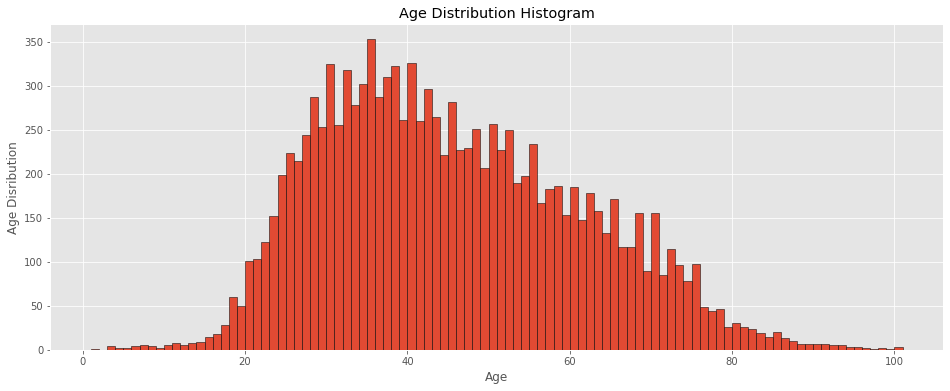

In [12]:
# Train Data for Age
get_hist_of_age(bins=100, ages = train_labels)

In [13]:
# Model
print('=====> Building model...')
model = resnet50(fds=args.fds, bucket_num=args.bucket_num, bucket_start=args.bucket_start,
                 start_update=args.start_update, start_smooth=args.start_smooth,
                 kernel=args.fds_kernel, ks=args.fds_ks, sigma=args.fds_sigma, momentum=args.fds_mmt)
model = torch.nn.DataParallel(model)
print(model)

=====> Building model...
DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsa

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

In [15]:
def train(train_loader, model, optimizer, epoch):
    batch_time = AverageMeter('Time', ':6.2f')
    data_time = AverageMeter('Data', ':6.4f')
    losses = AverageMeter(f'Loss ({args.loss.upper()})', ':.3f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses],
        prefix="Epoch: [{}]".format(epoch)
    )

    print("Training...")
    model.train()
    end = time.time()
    print("Load train loader")
    for idx, (inputs, targets, weights) in enumerate(train_loader):
        data_time.update(time.time() - end)
        print(idx)
        #inputs, targets, weights = \
        #    inputs.cuda(non_blocking=True), targets.cuda(non_blocking=True), weights.cuda(non_blocking=True)
        if args.fds:
            print("FDS enable")
            outputs, _ = model(inputs, targets, epoch)
        else:
            print("FDS disable")
            outputs = model(inputs, targets, epoch)

        print("Calculate Loss")
        loss = globals()[f"weighted_{args.loss}_loss"](outputs, targets, weights)
        assert not (np.isnan(loss.item()) or loss.item() > 1e6), f"Loss explosion: {loss.item()}"

        print("Update Loss")
        losses.update(loss.item(), inputs.size(0))

        optimizer.zero_grad()
        print("Backward")
        loss.backward()
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()
        if idx % args.print_freq == 0:
            progress.display(idx)

    print("Check FDS")
    if args.fds and epoch >= args.start_update:
        print(f"Create Epoch [{epoch}] features of all training data...")
        encodings, labels = [], []
        with torch.no_grad():
            for (inputs, targets, _) in tqdm(train_loader):
                #inputs = inputs.cuda(non_blocking=True)
                outputs, feature = model(inputs, targets, epoch)
                encodings.extend(feature.data.squeeze().cpu().numpy())
                labels.extend(targets.data.squeeze().cpu().numpy())

        encodings, labels = torch.from_numpy(np.vstack(encodings)), torch.from_numpy(np.hstack(labels))
        model.module.FDS.update_last_epoch_stats(epoch)
        model.module.FDS.update_running_stats(encodings, labels, epoch)

    return losses.avg

In [16]:
def validate(val_loader, model, train_labels=None, prefix='Val'):
    batch_time = AverageMeter('Time', ':6.3f')
    losses_mse = AverageMeter('Loss (MSE)', ':.3f')
    losses_l1 = AverageMeter('Loss (L1)', ':.3f')
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses_mse, losses_l1],
        prefix=f'{prefix}: '
    )

    criterion_mse = nn.MSELoss()
    criterion_l1 = nn.L1Loss()
    criterion_gmean = nn.L1Loss(reduction='none')

    model.eval()
    losses_all = []
    preds, labels = [], []
    with torch.no_grad():
        end = time.time()
        for idx, (inputs, targets, _) in enumerate(val_loader):
            #inputs, targets = inputs.cuda(non_blocking=True), targets.cuda(non_blocking=True)
            outputs = model(inputs)

            preds.extend(outputs.data.cpu().numpy())
            labels.extend(targets.data.cpu().numpy())

            loss_mse = criterion_mse(outputs, targets)
            loss_l1 = criterion_l1(outputs, targets)
            loss_all = criterion_gmean(outputs, targets)
            losses_all.extend(loss_all.cpu().numpy())

            losses_mse.update(loss_mse.item(), inputs.size(0))
            losses_l1.update(loss_l1.item(), inputs.size(0))

            batch_time.update(time.time() - end)
            end = time.time()
            if idx % args.print_freq == 0:
                progress.display(idx)

        shot_dict = shot_metrics(np.hstack(preds), np.hstack(labels), train_labels)
        loss_gmean = gmean(np.hstack(losses_all), axis=None).astype(float)
        print(f" * Overall: MSE {losses_mse.avg:.3f}\tL1 {losses_l1.avg:.3f}\tG-Mean {loss_gmean:.3f}")
        print(f" * Many: MSE {shot_dict['many']['mse']:.3f}\t"
              f"L1 {shot_dict['many']['l1']:.3f}\tG-Mean {shot_dict['many']['gmean']:.3f}")
        print(f" * Median: MSE {shot_dict['median']['mse']:.3f}\t"
              f"L1 {shot_dict['median']['l1']:.3f}\tG-Mean {shot_dict['median']['gmean']:.3f}")
        print(f" * Low: MSE {shot_dict['low']['mse']:.3f}\t"
              f"L1 {shot_dict['low']['l1']:.3f}\tG-Mean {shot_dict['low']['gmean']:.3f}")

    return losses_mse.avg, losses_l1.avg, loss_gmean


In [17]:
def shot_metrics(preds, labels, train_labels, many_shot_thr=100, low_shot_thr=20):
    train_labels = np.array(train_labels).astype(int)

    if isinstance(preds, torch.Tensor):
        preds = preds.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
    elif isinstance(preds, np.ndarray):
        pass
    else:
        raise TypeError(f'Type ({type(preds)}) of predictions not supported')

    train_class_count, test_class_count = [], []
    mse_per_class, l1_per_class, l1_all_per_class = [], [], []
    for l in np.unique(labels):
        train_class_count.append(len(train_labels[train_labels == l]))
        test_class_count.append(len(labels[labels == l]))
        mse_per_class.append(np.sum((preds[labels == l] - labels[labels == l]) ** 2))
        l1_per_class.append(np.sum(np.abs(preds[labels == l] - labels[labels == l])))
        l1_all_per_class.append(np.abs(preds[labels == l] - labels[labels == l]))

    many_shot_mse, median_shot_mse, low_shot_mse = [], [], []
    many_shot_l1, median_shot_l1, low_shot_l1 = [], [], []
    many_shot_gmean, median_shot_gmean, low_shot_gmean = [], [], []
    many_shot_cnt, median_shot_cnt, low_shot_cnt = [], [], []

    for i in range(len(train_class_count)):
        if train_class_count[i] > many_shot_thr:
            many_shot_mse.append(mse_per_class[i])
            many_shot_l1.append(l1_per_class[i])
            many_shot_gmean += list(l1_all_per_class[i])
            many_shot_cnt.append(test_class_count[i])
        elif train_class_count[i] < low_shot_thr:
            low_shot_mse.append(mse_per_class[i])
            low_shot_l1.append(l1_per_class[i])
            low_shot_gmean += list(l1_all_per_class[i])
            low_shot_cnt.append(test_class_count[i])
        else:
            median_shot_mse.append(mse_per_class[i])
            median_shot_l1.append(l1_per_class[i])
            median_shot_gmean += list(l1_all_per_class[i])
            median_shot_cnt.append(test_class_count[i])

    shot_dict = defaultdict(dict)
    shot_dict['many']['mse'] = np.sum(many_shot_mse) / np.sum(many_shot_cnt)
    shot_dict['many']['l1'] = np.sum(many_shot_l1) / np.sum(many_shot_cnt)
    shot_dict['many']['gmean'] = gmean(np.hstack(many_shot_gmean), axis=None).astype(float)
    shot_dict['median']['mse'] = np.sum(median_shot_mse) / np.sum(median_shot_cnt)
    shot_dict['median']['l1'] = np.sum(median_shot_l1) / np.sum(median_shot_cnt)
    shot_dict['median']['gmean'] = gmean(np.hstack(median_shot_gmean), axis=None).astype(float)
    shot_dict['low']['mse'] = np.sum(low_shot_mse) / np.sum(low_shot_cnt)
    shot_dict['low']['l1'] = np.sum(low_shot_l1) / np.sum(low_shot_cnt)
    shot_dict['low']['gmean'] = gmean(np.hstack(low_shot_gmean), axis=None).astype(float)

    return shot_dict

In [ ]:
for epoch in range(args.start_epoch, args.epoch):
        adjust_learning_rate(optimizer, epoch, args)
        train_loss = train(train_loader, model, optimizer, epoch)
        val_loss_mse, val_loss_l1, val_loss_gmean = validate(val_loader, model, train_labels=train_labels)

        loss_metric = val_loss_mse if args.loss == 'mse' else val_loss_l1
        is_best = loss_metric < args.best_loss
        args.best_loss = min(loss_metric, args.best_loss)
        print(f"Best {'L1' if 'l1' in args.loss else 'MSE'} Loss: {args.best_loss:.3f}")
        print(f"Epoch #{epoch}: Train loss [{train_loss:.4f}]; "
              f"Val loss: MSE [{val_loss_mse:.4f}], L1 [{val_loss_l1:.4f}], G-Mean [{val_loss_gmean:.4f}]")

Training...
Load train loader
0
FDS disable
